# Stefano Benetti 4905781

# CONLL "GUM" - Named Entity Recognition

The GUM corpus was created and annotated at Georgetown University.
It is collected and expanded by students as part of the curriculum in LING-367 Computational Corpus Linguistics at Georgetown University. The selection of text types is meant to represent different communicative purposes and topics like interviews, voyages, news stories and so on. 

https://corpling.uis.georgetown.edu/gum

The annotations are in the IOB format (inside, outside, beginning scheme) as follows:

```
Alex B-PER
is O
going O
to O
Los B-LOC
Angeles I-LOC
in O
California B-LOC
```

Here we have the entities represented by the TAGS:

```
Person
Place
Organization
Quantity
Time
Event
Abstract
Substance
Object
Animal
Plan
```

# Project summary: 

The project consists in the creation of some neural networks (purely recurrent, since we are dealing with sequential data) with Word Embedding, which allows to store both semantic and syntactic information of words and to build a vector space in which word vectors are closer if the words occur in the same linguistic contexts, i.e. if they are recognised as semantically more similar.

Neural Networks: 
- Simple Long Short Term Memory 
- Simple Gated Recurrent Unit
- Bidirectional Long Short Term Memory 
- Bidirectional Long Short Term Memory - Conditional Random Fields

### Importing libraries

In [1]:
import urllib
import sklearn
import logging
import os
import numpy as np
from seqeval.metrics import classification_report 
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

Using TensorFlow backend.
C:\Users\Stefano\.desktop\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Stefano\.desktop\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Stefano\.desktop\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\Stefano\.desktop\lib\site-packages\tensorflow\python\framework\dtype

### Loading the dataset 

In [2]:
#Reading the file from an URL and get a list for each sentence. 
#(Our sentences will be included in another list. Therefore, we will have a list of lists). 
CONLL_URL_ROOT = "https://drive.google.com/drive/folders/1Z5YThx1bXX0AEsYXb9l4QenogT40_5Nh"
def open_read_from_url(url):
    print(f"Read file from {url}")
    file = urllib.request.urlopen(url)
    lines = []
    for line in file:
        lines.append(line.decode("utf-8"))

    return lines

#Now, we read each line and parse the annotation format
#We extract for each token the entity annotation value that we will use for the train_set
def read_raw_conll(url_root, dir_path, filename):
    lines = []
    path = os.path.join(dir_path, filename)
    full_url = url_root + filename
    if os.path.isfile(path):
        
        print(f'Reading file {path}')
        with open(path, 'r', encoding='utf-8') as f:
            lines = f.readlines()
    else:
        lines = open_read_from_url(full_url)
    return lines[2:]


#This function basically checks, for each row, if we have a sentence or a blank space 
#the structure of the dataset contains a empty row every time a sentence ends
def is_real_sentence(only_token, sentence):
    first_word = ""
    if only_token:
        first_word = sentence[0]
    else:
        first_word = sentence[0][0]

    if '---------------------' in first_word or first_word == '-DOCSTART-':
        return False
    else:
        return True
    
    
#load_conll_data reads the file and returns the elements that we want: the list of lists regarding 
#sentences, the list of lists regarding the TAG and the set of the unique labels
def load_conll_data(filename, url_root=CONLL_URL_ROOT, dir_path='', 
                    only_tokens=False):
    lines = read_raw_conll(url_root, dir_path, filename)
    X = []
    Y = []
    sentence = []
    labels = []
    output_labels=set()
    for line in lines:
        if line == "\n":
            if(len(sentence) != len(labels)):
                print(f"Error: we have {len(sentence)} words but {len(labels)} labels")
            if sentence and is_real_sentence(only_tokens, sentence):
                X.append(sentence)
                Y.append(labels)
            sentence = []
            labels = []
        else:
            features = line.split()
            tag = features.pop()
            labels.append(tag)
            output_labels.add(tag)
            if only_tokens:
                sentence.append(features.pop(0))
            else:
                sentence.append(tuple(features))
    
    print(f"Read {len(X)} sentences")
    if(len(X) != len(Y)):
        print("ERROR in reading data.")
    return X, Y, output_labels


In [3]:
#we read the file from the local folder
data_dir = os.path.join('CONLL-format', 'data')
raw_train, ner_train, __ = load_conll_data('gum-train.conll', dir_path=data_dir, only_tokens=True)
raw_test, ner_test, output_labels = load_conll_data('gum-test.conll', dir_path=data_dir, only_tokens=True)

Reading file CONLL-format\data\gum-train.conll
Read 2494 sentences
Reading file CONLL-format\data\gum-test.conll
Read 999 sentences


In [4]:
print(raw_train[0], type(raw_train))
print(ner_train[0], type(ner_train))
print(output_labels, type(output_labels))

['back', 'of', 'my', 'jersey', 'says', '"', 'The', 'Poet', "'", 'because', 'growing', 'up', 'that', 'was', 'my', 'nickname', '.'] <class 'list'>
['I-object', 'I-object', 'I-object', 'I-object', 'O', 'B-abstract', 'I-abstract', 'I-abstract', 'I-abstract', 'O', 'O', 'O', 'B-abstract', 'O', 'B-person', 'O', 'O'] <class 'list'>
{'I-organization', 'B-place', 'B-object', 'I-event', 'I-time', 'I-animal', 'B-quantity', 'O', 'I-abstract', 'I-object', 'B-event', 'B-organization', 'B-animal', 'B-time', 'B-person', 'B-plant', 'I-quantity', 'B-abstract', 'I-person', 'I-plant', 'B-substance', 'I-place', 'I-substance'} <class 'set'>


### DATA EXPLORATORY ANALYSIS 

Let's temporary transform our data in a pandas dataframe, in order to facilitate our statistical analysis. 

In [5]:
import itertools
import pandas as pd
#let's extracting all the elements of all the lists in the train_set sentences
#and put them in a unique list
merged1_train= list(itertools.chain(*ner_train))
df_ner_train = pd.DataFrame(merged1_train, columns = ['TAG'])

merged2_train = list(itertools.chain(*raw_train))
df_raw_train = pd.DataFrame(merged2_train, columns = ['word'])

#joining dataframe to create a unique dataframe 
df_train = df_raw_train.join(df_ner_train)


#let's do the same for test set 
merged1_test= list(itertools.chain(*ner_test))
df_ner_test = pd.DataFrame(merged1_test, columns = ['TAG'])

merged2_test = list(itertools.chain(*raw_test))
df_raw_test = pd.DataFrame(merged2_test, columns = ['word'])
 
df_test = df_raw_test.join(df_ner_test)

df_train.head(20)

,word,TAG
0,back,I-object
1,of,I-object
2,my,I-object
3,jersey,I-object
4,says,O
5,"""",B-abstract
6,The,I-abstract
7,Poet,I-abstract
8,',I-abstract
9,because,O


In [6]:
categories = df_ner_train.groupby('TAG')
print("total categories:", categories.ngroups)
print(categories.size())

total categories: 23
TAG
B-abstract         2002
B-animal            141
B-event             738
B-object           1015
B-organization      397
B-person           1919
B-place            1150
B-plant             144
B-quantity           97
B-substance         278
B-time              401
I-abstract         4687
I-animal            120
I-event            2707
I-object           1731
I-organization      552
I-person           1866
I-place            2212
I-plant             166
I-quantity          203
I-substance         458
I-time              663
O                 20442
dtype: int64


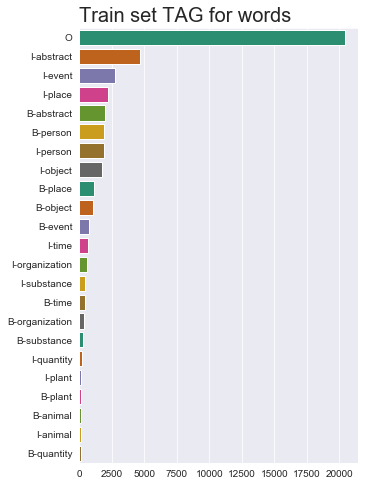

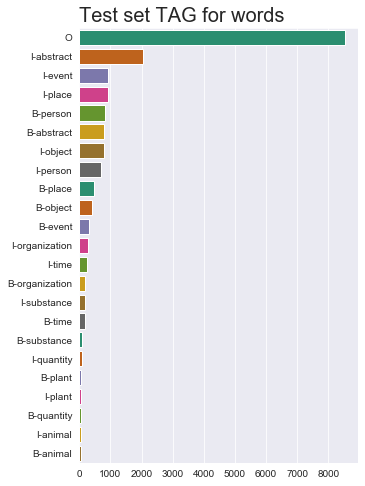

In [7]:
import matplotlib.pyplot as plt 
import seaborn as sb 
count = (df_ner_train['TAG'].value_counts()).reset_index()
sb.set_style('darkgrid')
plt.figure(figsize=(5, 8))
sb.barplot(data=count, y='index', x='TAG', palette='Dark2')
plt.title('Train set TAG for words', loc='left', fontsize=20)
plt.xlabel("")
plt.ylabel("")
plt.show()

count = (df_ner_test['TAG'].value_counts()).reset_index()
sb.set_style('darkgrid')
plt.figure(figsize=(5, 8))
sb.barplot(data=count, y='index', x='TAG', palette='Dark2')
plt.title('Test set TAG for words', loc='left', fontsize=20)
plt.xlabel("")
plt.ylabel("")
plt.show()

As we can see our datasets are very ubalanced. This is due to the fact that our problem is a Named Entity Recognition: all characters are important (or at least useful for our purpose), including punctuation and stopwords. This two type of character, are classified as "O" ("Outside"), but they are not recognized as an entity, in contrast to other words. 

Moreover, we are few observation for, for example, B-Quantity or I-animal. Therefore, the models will certainly have problems recognising and classifying them as such, whereas for punctuation and stopwords it will have fewer problems.

Now, let's check what kind of words we have for some entities: I-abstract, O and B-person

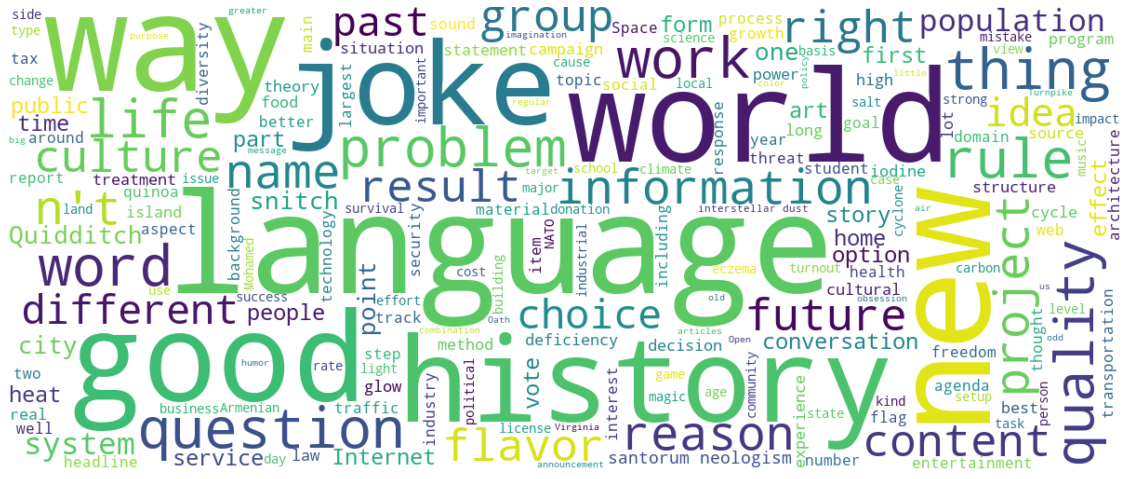

In [8]:
from wordcloud import WordCloud
def create_wordcloud(TAG):
    text = " ".join(word for word in df_train[df_train['TAG'] == TAG].word)
    wordcloud = WordCloud(width=1200, height=500, max_font_size=150, background_color = 'white').generate(text)
    plt.figure(figsize=(20,15))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()
    
create_wordcloud("I-abstract")

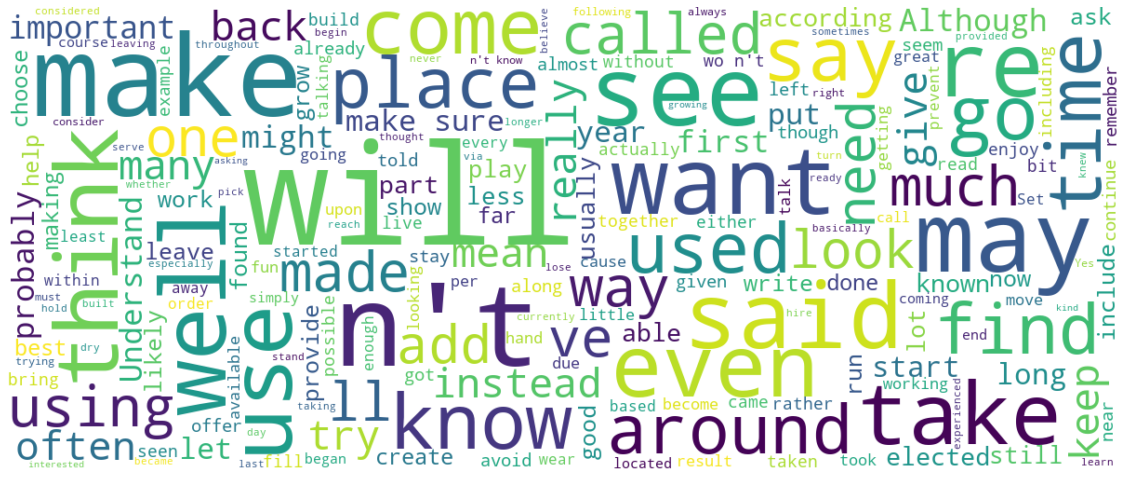

In [9]:
create_wordcloud("O")

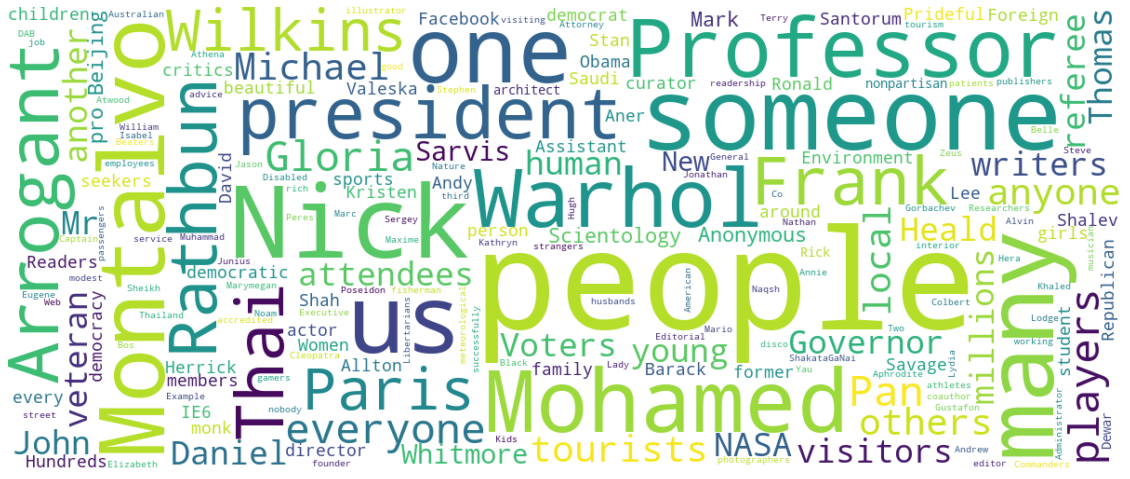

In [10]:
create_wordcloud("B-person")

### Creating a validation set 

Thanks to the validation set, we will have an immediate evaluation in our model on a dataset on which it has not been trained. This way we can adjust the parameters to be estimated before moving on to the testing phase.

In [11]:
raw_valid = raw_train[0:1000]
ner_valid = ner_train[0:1000]

del raw_train[0:1000]
del ner_train[0:1000]

print("Number of observation for Train Set:" , len(raw_train))
print("Number of observation for Validation Set:", len(raw_valid))
print("Number of observation for Test Set:", len(raw_test))

Number of observation for Train Set: 1494
Number of observation for Validation Set: 1000
Number of observation for Test Set: 999


We are dealing with a small number of observation. We will have some problems in training our models on this data quantity

Now we can pass to the preprocessing step, where we format the data to make it "readable" by our models 

# Word Embedding

### Tokenization 

First of all we tokenize our data. Then, we transform them into sequences. Those sequences are composed by some numbers (as we can see below in the output of the code) and those numbers corresponds to the position of the words in the vocabulary. With "vocabulary" we mean that one in which all the words in the corpus are included. 

In [12]:
from keras.preprocessing.text import Tokenizer
token_tokenizer = Tokenizer()
token_tokenizer.fit_on_texts(raw_train + raw_valid + raw_test)

train_sequences = token_tokenizer.texts_to_sequences(raw_train)
valid_sequences = token_tokenizer.texts_to_sequences(raw_valid)
test_sequences = token_tokenizer.texts_to_sequences(raw_test)
print(train_sequences[0])
print(valid_sequences[0])
print(test_sequences[0])

[2163, 237, 6, 1722, 31, 2862, 1, 1193, 78, 46, 4, 1, 616, 676, 2164, 2]
[108, 4, 133, 1897, 360, 13, 1, 1120, 50, 116, 594, 76, 12, 22, 133, 3676, 2]
[1312, 1492, 3, 4110, 4111, 1455, 3, 2817, 1, 197, 437, 478, 17, 7, 1286, 2117, 26, 1, 910, 2, 30, 938, 29, 2]


In [13]:
vocabulary_size = len(token_tokenizer.word_counts)
print(vocabulary_size)

8714


### Assigning a number to each entity (labels)

Moreover, we need to transform in numbers labels too. Let's do it through a dictionary creation, in which keys are teh tags and the values is the unique number assigned to.  

In [14]:
tag2idx = { tag: idx for idx, tag in enumerate(output_labels) }
print ("tag2idx" +str(tag2idx))

idx2tag = { idx: tag for tag, idx in tag2idx.items() }
print ("idx2tag" +str(idx2tag))

tag2idx{'I-organization': 0, 'B-place': 1, 'B-object': 2, 'I-event': 3, 'I-time': 4, 'I-animal': 5, 'B-quantity': 6, 'O': 7, 'I-abstract': 8, 'I-object': 9, 'B-event': 10, 'B-organization': 11, 'B-animal': 12, 'B-time': 13, 'B-person': 14, 'B-plant': 15, 'I-quantity': 16, 'B-abstract': 17, 'I-person': 18, 'I-plant': 19, 'B-substance': 20, 'I-place': 21, 'I-substance': 22}
idx2tag{0: 'I-organization', 1: 'B-place', 2: 'B-object', 3: 'I-event', 4: 'I-time', 5: 'I-animal', 6: 'B-quantity', 7: 'O', 8: 'I-abstract', 9: 'I-object', 10: 'B-event', 11: 'B-organization', 12: 'B-animal', 13: 'B-time', 14: 'B-person', 15: 'B-plant', 16: 'I-quantity', 17: 'B-abstract', 18: 'I-person', 19: 'I-plant', 20: 'B-substance', 21: 'I-place', 22: 'I-substance'}


In [15]:
ner_train_sequences = [[tag2idx[tag] for tag in sentence] for sentence in ner_train]
ner_valid_sequences = [[tag2idx[tag] for tag in sentence] for sentence in ner_valid]
ner_test_sequences  = [[tag2idx[tag] for tag in sentence] for sentence in ner_test ]


### Padding 

We know that in order to pass data to neural networks with word embedding, we must have sentences of the same length. Therefore, thanks to the pad_sequences function of Keras, we are going to set a length for all the sentences and, while truncating the longer sentences, we are going to add zeros (pads) to the shorter ones.
But first of all let's check the overall trend in the length of sentences.

In [16]:
sequence_len = np.array([len(s) for s in train_sequences])
longest_sequence = sequence_len.max()
print(f'Longest sequence: {longest_sequence}')

print([(str(p) + '%', np.percentile(sequence_len, p)) for p in range(80,101,1)])

Longest sequence: 94
[('80%', 27.0), ('81%', 28.0), ('82%', 28.0), ('83%', 29.0), ('84%', 29.0), ('85%', 30.0), ('86%', 31.0), ('87%', 31.0), ('88%', 32.0), ('89%', 32.76999999999998), ('90%', 33.0), ('91%', 34.0), ('92%', 35.0), ('93%', 36.0), ('94%', 37.0), ('95%', 39.0), ('96%', 41.0), ('97%', 44.0), ('98%', 48.0), ('99%', 53.13999999999987), ('100%', 94.0)]


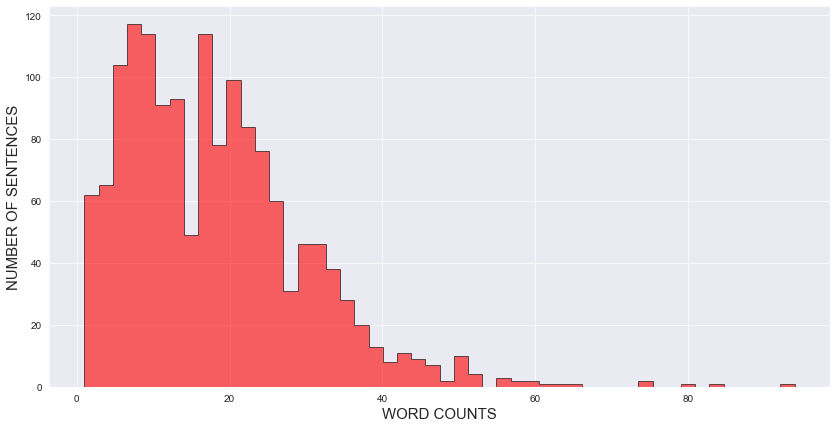

In [17]:
plt.figure(figsize=(14,7))
plt.hist(sequence_len, bins = 50, histtype = "stepfilled", color = "red", alpha = 0.6,
         edgecolor = "black")
plt.xlabel("WORD COUNTS", size = 15)
plt.ylabel("NUMBER OF SENTENCES", size = 15)
plt.show()

Dealing with a NER problem, perhaps it would be better to set the length of the sentence longer, in order to take all words into account (also considering the small size of the dataset).

In [18]:
max_sequence_len = 94
X_train = pad_sequences(train_sequences, maxlen=max_sequence_len, padding='post', truncating='post')
X_valid = pad_sequences(valid_sequences, maxlen=max_sequence_len, padding='post', truncating='post')
X_test = pad_sequences(test_sequences, maxlen=max_sequence_len, padding='post', truncating='post')

Y_train = pad_sequences(ner_train_sequences, maxlen=max_sequence_len, value=tag2idx['O'], padding='post', truncating='post')
Y_valid = pad_sequences(ner_valid_sequences, maxlen=max_sequence_len, value=tag2idx['O'], padding='post', truncating='post')
Y_test = pad_sequences(ner_test_sequences, maxlen=max_sequence_len, value=tag2idx['O'], padding='post', truncating='post')

In [19]:
print(X_train[0])
print(Y_train[0])

[2163  237    6 1722   31 2862    1 1193   78   46    4    1  616  676
 2164    2    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0]
[14  7  7  7  7  7  2  9  7  2  9  9  9  9  9  7  7  7  7  7  7  7  7  7
  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7
  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7
  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7]


### Getting dummy variables

We create convenience variables to facilitate the model's classification process.

In [20]:
Y_train = to_categorical(Y_train, num_classes=len(output_labels), dtype='int32')
Y_valid = to_categorical(Y_valid, num_classes=len(output_labels), dtype='int32')
Y_test = to_categorical(Y_test, num_classes=len(output_labels), dtype='int32')
print(X_train[0])
print(Y_train[0])

[2163  237    6 1722   31 2862    1 1193   78   46    4    1  616  676
 2164    2    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0]
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


### Converting in arrays 

Let's convert our data in arrays in order to make them readable by our models

In [21]:
X_train = np.array(X_train) 
Y_train = np.array(Y_train)

X_valid = np.array(X_valid)
Y_valid = np.array(Y_valid)

X_test = np.array(X_test)
Y_test = np.array(Y_test)

In [22]:
print(X_train.shape)
print(Y_train.shape)
print(X_valid.shape)
print(Y_valid.shape)
print(X_test.shape)
print(Y_test.shape)

(1494, 94)
(1494, 94, 23)
(1000, 94)
(1000, 94, 23)
(999, 94)
(999, 94, 23)


### Embedding matrix creation 

We are going to use as embedding through the glove embedding. It is available here: https://nlp.stanford.edu/projects/glove/.
We are going to use the glove.6B version that contains 6 billions of tokens and 4K vocabulary terms in lower case. Those tokens are provided with feature vectors of 50/100/200/300 dimensions.

This is a big file in which for each element (characters and words) we have the vector of features.

In [23]:
#We define a function in order to load and use this glove embedding
#We open the file and read line by line. Then we split values because we have lines made of tokens 
#and list of numbers. Then we create the embedding matrix
def load_glove_embedding_matrix(path, word_index, embed_dim):
    embeddings_index = {}
    with open(path, encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs

    print('Found %s word vectors.' % len(embeddings_index))
    embedding_matrix = np.zeros((len(word_index) + 1, embed_dim))
    for word, i in word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            # words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector
    
    return embedding_matrix


In [24]:
glove_embedding_path = os.path.join('CONLL-format', 'data', 'glove.6B.100d.txt')
embed_dim = 100
glove_matrix = load_glove_embedding_matrix(glove_embedding_path, token_tokenizer.word_index, embed_dim)

Found 400000 word vectors.


Great, now we are ready to create and train our first model.
Since we are dealing with a very unbalanced dataset, the Accuracy metrics will be not useful for 
the model evaluation. We need to check the Recall and Precision metrics. 

First of all we define some global variables: number of classes or TAG (23), in order to predict 
our output and the sequences length, that is our max sequence length (94) that we used to pad 
the sequences
They are global variables because we use them for all our models

In [25]:
n_classes = len(output_labels)
seq_len = max_sequence_len
batch_size = 10 
hidden_cells = 50

The other variables are assigned as local, because they are not the same for all the models

# Simple LSTM 

In [26]:
#Let's define our first model 
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Dropout, Bidirectional 
from tensorflow.keras.metrics import Precision, Recall


from keras.layers import LSTM

def Simple_LSTM (vocabulary_size, seq_len, n_classes, hidden_cells=hidden_cells, 
                  embed_dim=embed_dim, drop=0.5, weights = [glove_matrix], mask_zero = True, trainable = True):
    
    model = Sequential()
    
    model.add(Embedding(vocabulary_size, embed_dim))
    
    model.add(LSTM(hidden_cells, dropout = drop, activation = "relu", return_sequences = True))
    
    model.add(Dense(n_classes, activation = "softmax"))
    
    model.compile(loss= 'categorical_crossentropy', 
                  optimizer='adam',
                  metrics=["accuracy", Precision(), Recall()])
    
    model.summary()
    
    
    return model

In [27]:
#Taking a look to the model summary, including the number of weights that have to be estimated 
model_1 = Simple_LSTM(vocabulary_size+1, max_sequence_len, len(output_labels))

Instructions for updating:
Colocations handled automatically by placer.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 100)         871500    
_________________________________________________________________
lstm_1 (LSTM)                (None, None, 50)          30200     
_________________________________________________________________
dense_1 (Dense)              (None, None, 23)          1173      
Total params: 902,873
Trainable params: 902,873
Non-trainable params: 0
_________________________________________________________________


In [28]:
#We let the train phase begin
history_1 = model_1.fit(X_train,Y_train, batch_size=batch_size, epochs=15, verbose=1,
          validation_data=(X_valid, Y_valid))

Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Train on 1494 samples, validate on 1000 samples
Epoch 1/15
1494/1494 [==============================] - 17s 11ms/step - loss: 0.8868 - accuracy: 0.8760 - precision: 0.8775 - recall: 0.4774 - val_loss: 0.4423 - val_accuracy: 0.9045 - val_precision: 0.9926 - val_recall: 0.7226
Epoch 2/15
1494/1494 [==============================] - 15s 10ms/step - loss: 0.9123 - accuracy: 0.8891 - precision: 0.9843 - recall: 0.7669 - val_loss: 0.8462 - val_accuracy: 0.8951 - val_precision: 0.9689 - val_recall: 0.7922
Epoch 3/15
1494/1494 [==============================] - 15s 10ms/step - loss: 0.8757 - accuracy: 0.8789 - precision: 0.9633 - recall: 0.8019 - val_loss: 0.4455 - val_accuracy: 0.9043 - val_precision: 0.9671 - val_recall: 0.8054
Epoch 4/15
1494/1494 [==============================] - 15s 10ms/step - loss: 0.4815 - accuracy: 0.8954 - precision: 0.9707 - recall: 0.8086 -

In [29]:
#Finally, we can check the performance on test set 
results_1 = model_1.evaluate(X_test, Y_test, verbose=0)
print('Test set\n  Loss: {:0.3f}\n  Precision: {:0.3f}\n  Recall: {:0.3f}'.format(results_1[0],results_1[2],results_1[3]))

Test set
  Loss: 0.381
  Precision: 0.982
  Recall: 0.840


# Gated Recurrent Unit

In [30]:
from keras.layers import GRU
def Simple_GRU (vocabulary_size, seq_len, n_classes, hidden_cells=50, 
                  embed_dim=embed_dim, drop=0.5, weights = [glove_matrix], mask_zero = True, trainable = True):
    
    model = Sequential()
    
    model.add(Embedding(vocabulary_size, embed_dim))
    
    model.add(GRU(hidden_cells, dropout = drop, activation = "relu", return_sequences = True))
    
    model.add(Dense(n_classes, activation = "softmax"))
    
    model.compile(loss= 'categorical_crossentropy', 
                  optimizer='adam',
                  metrics=["accuracy", Precision(), Recall()])
    
    model.summary()
    
    
    return model

In [31]:
model_2 = Simple_GRU(vocabulary_size+1, max_sequence_len, len(output_labels))

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 100)         871500    
_________________________________________________________________
gru_1 (GRU)                  (None, None, 50)          22650     
_________________________________________________________________
dense_2 (Dense)              (None, None, 23)          1173      
Total params: 895,323
Trainable params: 895,323
Non-trainable params: 0
_________________________________________________________________


In [32]:
history_2 = model_2.fit(X_train,Y_train, batch_size=batch_size, epochs=15, verbose=1,
          validation_data=(X_valid, Y_valid))

Train on 1494 samples, validate on 1000 samples
Epoch 1/15
1494/1494 [==============================] - 19s 13ms/step - loss: 0.9320 - accuracy: 0.8754 - precision_1: 0.7891 - recall_1: 0.3786 - val_loss: 0.3965 - val_accuracy: 0.9045 - val_precision_1: 0.9823 - val_recall_1: 0.6975
Epoch 2/15
1494/1494 [==============================] - 17s 11ms/step - loss: 0.4001 - accuracy: 0.8960 - precision_1: 0.9818 - recall_1: 0.7566 - val_loss: 0.3467 - val_accuracy: 0.9068 - val_precision_1: 0.9816 - val_recall_1: 0.7876
Epoch 3/15
1494/1494 [==============================] - 17s 11ms/step - loss: 0.3495 - accuracy: 0.9020 - precision_1: 0.9821 - recall_1: 0.8060 - val_loss: 0.3125 - val_accuracy: 0.9140 - val_precision_1: 0.9826 - val_recall_1: 0.8184
Epoch 4/15
1494/1494 [==============================] - 16s 10ms/step - loss: 0.3054 - accuracy: 0.9126 - precision_1: 0.9833 - recall_1: 0.8280 - val_loss: 0.2908 - val_accuracy: 0.9186 - val_precision_1: 0.9836 - val_recall_1: 0.8354
Epoch 5/

In [33]:
results_2 = model_2.evaluate(X_test, Y_test, verbose=0)
print('Test set\n  Loss: {:0.3f}\n  Precision: {:0.3f}\n  Recall: {:0.3f}'.format(results_2[0],results_2[2],results_2[3]))

Test set
  Loss: 0.347
  Precision: 0.981
  Recall: 0.894


# Bidirectional LSTM

In [71]:
def Bid_LSTM (vocabulary_size, seq_len, n_classes, hidden_cells=50, 
                  embed_dim=50, drop=0.5, weights = [glove_matrix], mask_zero = True, trainable = True):
    
    model = Sequential()
    
    model.add(Embedding(vocabulary_size, embed_dim, input_length=seq_len)) 
    
    model.add(Dropout(drop))
    
    model.add(Bidirectional(LSTM(hidden_cells, return_sequences=True, dropout = drop)))
    
    model.add(Dense(n_classes, activation = "softmax"))
    
    model.compile(loss= 'categorical_crossentropy', 
                  optimizer="rmsprop",
                  metrics=["accuracy", Precision(), Recall()])
    
    model.summary()
    
    
    return model

In [72]:
model_3 = Bid_LSTM(vocabulary_size+1, max_sequence_len, len(output_labels))

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_11 (Embedding)     (None, 94, 50)            435750    
_________________________________________________________________
dropout_9 (Dropout)          (None, 94, 50)            0         
_________________________________________________________________
bidirectional_9 (Bidirection (None, 94, 100)           40400     
_________________________________________________________________
dense_9 (Dense)              (None, 94, 23)            2323      
Total params: 478,473
Trainable params: 478,473
Non-trainable params: 0
_________________________________________________________________


In [73]:
history_3 = model_3.fit(X_train,Y_train, batch_size=batch_size, epochs=40, verbose=1,
          validation_data=(X_valid, Y_valid))

Train on 1494 samples, validate on 1000 samples
Epoch 1/40
1494/1494 [==============================] - 21s 14ms/step - loss: 0.5365 - accuracy: 0.8895 - precision_9: 0.8898 - recall_9: 0.7116 - val_loss: 0.3606 - val_accuracy: 0.9045 - val_precision_9: 0.9507 - val_recall_9: 0.8330
Epoch 2/40
1494/1494 [==============================] - 17s 12ms/step - loss: 0.3765 - accuracy: 0.8968 - precision_9: 0.9607 - recall_9: 0.8451 - val_loss: 0.3315 - val_accuracy: 0.9064 - val_precision_9: 0.9662 - val_recall_9: 0.8530
Epoch 3/40
1494/1494 [==============================] - 17s 12ms/step - loss: 0.3516 - accuracy: 0.9006 - precision_9: 0.9697 - recall_9: 0.8583 - val_loss: 0.3164 - val_accuracy: 0.9109 - val_precision_9: 0.9724 - val_recall_9: 0.8617
Epoch 4/40
1494/1494 [==============================] - 17s 12ms/step - loss: 0.3366 - accuracy: 0.9040 - precision_9: 0.9744 - recall_9: 0.8641 - val_loss: 0.3071 - val_accuracy: 0.9116 - val_precision_9: 0.9757 - val_recall_9: 0.8665
Epoch 5/

1494/1494 [==============================] - 18s 12ms/step - loss: 0.1663 - accuracy: 0.9508 - precision_9: 0.9799 - recall_9: 0.8985 - val_loss: 0.2575 - val_accuracy: 0.9290 - val_precision_9: 0.9798 - val_recall_9: 0.8988
Epoch 36/40
1494/1494 [==============================] - 18s 12ms/step - loss: 0.1617 - accuracy: 0.9522 - precision_9: 0.9797 - recall_9: 0.8992 - val_loss: 0.2540 - val_accuracy: 0.9306 - val_precision_9: 0.9796 - val_recall_9: 0.8996
Epoch 37/40
1494/1494 [==============================] - 18s 12ms/step - loss: 0.1590 - accuracy: 0.9532 - precision_9: 0.9795 - recall_9: 0.9000 - val_loss: 0.2536 - val_accuracy: 0.9304 - val_precision_9: 0.9794 - val_recall_9: 0.9003
Epoch 38/40
1494/1494 [==============================] - 18s 12ms/step - loss: 0.1545 - accuracy: 0.9535 - precision_9: 0.9793 - recall_9: 0.9007 - val_loss: 0.2627 - val_accuracy: 0.9300 - val_precision_9: 0.9793 - val_recall_9: 0.9010
Epoch 39/40
1494/1494 [==============================] - 18s 12m

In [74]:
results_3 = model_3.evaluate(X_test, Y_test, verbose=0)
print('Test set\n  Loss: {:0.3f}\n  Precision: {:0.3f}\n  Recall: {:0.3f}'.format(results_3[0],results_3[2],results_3[3]))

Test set
  Loss: 0.285
  Precision: 0.979
  Recall: 0.903


# Bidirectional LSTM-CRF

Conditional Random Fields is an algorithm for sequence labelling based on markov chains.
The peculiarity of CRF regards the classification purpose. It focuses on sentence level instead of individual positions.
This model included in the literature is very suggested for NER problems.

In [38]:
from keras_contrib.layers import CRF
from tensorflow.keras.metrics import Precision, Recall

crf = CRF(n_classes)

def Bid_LSTM_CRF (vocabulary_size, seq_len, n_classes, hidden_cells=50, 
                  embed_dim=50, drop=0.5, weights=[glove_matrix], mask_zero = True, trainable = True):
    model = Sequential()
    
    model.add(Embedding(vocabulary_size, embed_dim, input_length=seq_len)) 
    
    model.add(Dropout(drop))
    
    model.add(Bidirectional(LSTM(hidden_cells, return_sequences=True, 
                                 dropout=drop)))
    model.add(Dropout(drop))
    
    model.add(crf)
    
    model.compile(loss=crf.loss_function, 
                  optimizer='rmsprop',
                  metrics=[crf.accuracy, Precision(), Recall()])
    model.summary()
                  
    return model

In [39]:
model_4 = Bid_LSTM_CRF (vocabulary_size+1, max_sequence_len, len(output_labels))

C:\Users\Stefano\OneDrive\Desktop\GUM\GUM\keras_contrib\layers\crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
C:\Users\Stefano\OneDrive\Desktop\GUM\GUM\keras_contrib\layers\crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 94, 50)            435750    
_________________________________________________________________
dropout_2 (Dropout)          (None, 94, 50)            0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 94, 100)           40400     
_________________________________________________________________
dropout_3 (Dropout)          (None, 94, 100)           0         
_________________________________________________________________
crf_1 (CRF)                  (None, 94, 23)            2898      
Total params: 479,048
Trainable params: 479,048
Non-trainable params: 0
_________________________________________________________________


In [40]:
history_4 = model_4.fit(X_train,Y_train, batch_size=batch_size, epochs = 80, verbose=1,
          validation_data=(X_valid, Y_valid))

Train on 1494 samples, validate on 1000 samples
Epoch 1/80
1494/1494 [==============================] - 37s 25ms/step - loss: 0.5438 - crf_viterbi_accuracy: 0.8720 - precision_3: 0.0000e+00 - recall_3: 0.0000e+00 - val_loss: 0.3492 - val_crf_viterbi_accuracy: 0.9045 - val_precision_3: 0.9051 - val_recall_3: 0.2139
Epoch 2/80
1494/1494 [==============================] - 33s 22ms/step - loss: 0.3605 - crf_viterbi_accuracy: 0.8964 - precision_3: 0.9045 - recall_3: 0.2835 - val_loss: 0.3033 - val_crf_viterbi_accuracy: 0.9073 - val_precision_3: 0.9053 - val_recall_3: 0.3008
Epoch 3/80
1494/1494 [==============================] - 34s 22ms/step - loss: 0.3159 - crf_viterbi_accuracy: 0.8991 - precision_3: 0.9059 - recall_3: 0.3173 - val_loss: 0.2710 - val_crf_viterbi_accuracy: 0.9101 - val_precision_3: 0.9067 - val_recall_3: 0.3241iterbi
Epoch 4/80
1494/1494 [==============================] - 34s 23ms/step - loss: 0.2835 - crf_viterbi_accuracy: 0.9013 - precision_3: 0.9073 - recall_3: 0.3314 -

1494/1494 [==============================] - 58s 39ms/step - loss: 0.0411 - crf_viterbi_accuracy: 0.9386 - precision_3: 0.9147 - recall_3: 0.3630 - val_loss: 0.0654 - val_crf_viterbi_accuracy: 0.9264 - val_precision_3: 0.9149 - val_recall_3: 0.3632
Epoch 31/80
1494/1494 [==============================] - 58s 39ms/step - loss: 0.0381 - crf_viterbi_accuracy: 0.9413 - precision_3: 0.9151 - recall_3: 0.3633 - val_loss: 0.0640 - val_crf_viterbi_accuracy: 0.9196 - val_precision_3: 0.9152 - val_recall_3: 0.3634
Epoch 32/80
1494/1494 [==============================] - 56s 37ms/step - loss: 0.0334 - crf_viterbi_accuracy: 0.9421 - precision_3: 0.9153 - recall_3: 0.3634 - val_loss: 0.0629 - val_crf_viterbi_accuracy: 0.9243 - val_precision_3: 0.9154 - val_recall_3: 0.3636
Epoch 33/80
1494/1494 [==============================] - 31s 20ms/step - loss: 0.0308 - crf_viterbi_accuracy: 0.9450 - precision_3: 0.9155 - recall_3: 0.3637 - val_loss: 0.0594 - val_crf_viterbi_accuracy: 0.9242 - val_precision_3

1494/1494 [==============================] - 33s 22ms/step - loss: -0.0353 - crf_viterbi_accuracy: 0.9634 - precision_3: 0.9210 - recall_3: 0.3674 - val_loss: 0.0199 - val_crf_viterbi_accuracy: 0.9281 - val_precision_3: 0.9211 - val_recall_3: 0.3674
Epoch 60/80
1494/1494 [==============================] - 33s 22ms/step - loss: -0.0370 - crf_viterbi_accuracy: 0.9646 - precision_3: 0.9211 - recall_3: 0.3674 - val_loss: 0.0196 - val_crf_viterbi_accuracy: 0.9245 - val_precision_3: 0.9211 - val_recall_3: 0.3675 loss: -0.0370 - crf_viterbi_accura
Epoch 61/80
1494/1494 [==============================] - 34s 22ms/step - loss: -0.0393 - crf_viterbi_accuracy: 0.9649 - precision_3: 0.9212 - recall_3: 0.3675 - val_loss: 0.0173 - val_crf_viterbi_accuracy: 0.9319 - val_precision_3: 0.9213 - val_recall_3: 0.3676
Epoch 62/80
1494/1494 [==============================] - 34s 22ms/step - loss: -0.0407 - crf_viterbi_accuracy: 0.9648 - precision_3: 0.9213 - recall_3: 0.3676 - val_loss: 0.0167 - val_crf_vit

In [41]:
results_4 = model_4.evaluate(X_test, Y_test, verbose=0)
print('Test set\n  Loss: {:0.3f}\n  Precision: {:0.3f}\n  Recall: {:0.3f}'.format(results_4[0],results_4[2],results_4[3]))

Test set
  Loss: 0.010
  Precision: 0.924
  Recall: 0.372


# Results

Let's compare our models

In [42]:
print('Test set Simple_LSTM\n  Loss: {:0.3f}\n  Precision: {:0.3f}\n  Recall: {:0.3f}'.format(results_1[0],results_1[2],results_1[3]))
print('Test set GRU\n  Loss: {:0.3f}\n  Precision: {:0.3f}\n  Recall: {:0.3f}'.format(results_2[0],results_2[2],results_2[3]))
print('Test set Bidirectional_LSTM (the best one!)\n  Loss: {:0.3f}\n  Precision: {:0.3f}\n  Recall: {:0.3f}'.format(results_3[0],results_3[2],results_3[3]))
print('Test set Bidirectional_LSTM_CRF\n  Loss: {:0.3f}\n  Precision: {:0.3f}\n  Recall: {:0.3f}'.format(results_4[0],results_4[2],results_4[3]))

Test set Simple_LSTM
  Loss: 0.381
  Precision: 0.982
  Recall: 0.840
Test set GRU
  Loss: 0.347
  Precision: 0.981
  Recall: 0.894
Test set Bidirectional_LSTM (the best one!)
  Loss: 0.290
  Precision: 0.979
  Recall: 0.901
Test set Bidirectional_LSTM_CRF
  Loss: 0.010
  Precision: 0.924
  Recall: 0.372


As we can see, all four models seem to perform well in terms of accuracy. On the Recall, the Bidirectional LSTM CRF performs quite poorly. 
Most models had difficulty, however, in reaching the global minimum point of the cost function.

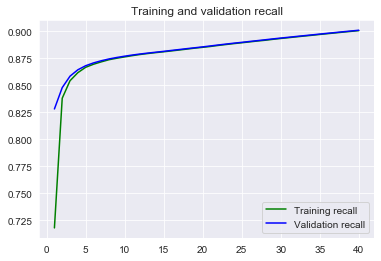

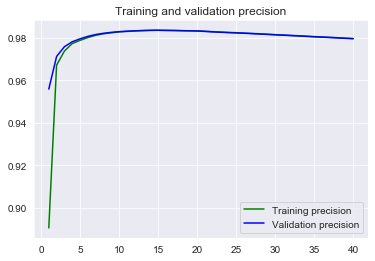

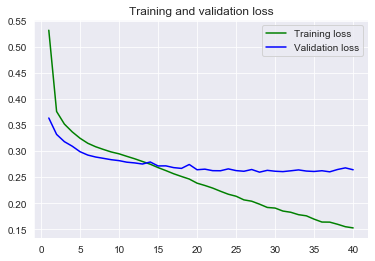

In [47]:
import matplotlib.pyplot as plt

recall = history_3.history['recall_2']
val_recall = history_3.history['val_recall_2']
precision = history_3.history['precision_2']
val_precision = history_3.history['val_precision_2']
loss = history_3.history['loss']
val_loss = history_3.history['val_loss']

epochs = range(1, len(recall) + 1)

plt.plot(epochs, recall, 'g', label='Training recall')
plt.plot(epochs, val_recall, 'b', label='Validation recall')
plt.title('Training and validation recall')
plt.legend()

plt.figure()

plt.plot(epochs, precision, 'g', label='Training precision')
plt.plot(epochs, val_precision, 'b', label='Validation precision')
plt.title('Training and validation precision')
plt.legend()

plt.figure()


plt.plot(epochs, loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

Now, let's see in practice how the best model behave on a sentence of the corpus. 

In [48]:
token_tokenizer.index_word[0]="_PAD_"

i = 15
sentence = X_test[i]
y_pred = model_3.predict(X_test)
y_pred = np.argmax(y_pred, axis=-1)
y_pred = y_pred[i]
y_true = np.argmax(Y_test, axis=-1)[i]
for idx in range(len(sentence)):
    print(f'{token_tokenizer.index_word[sentence[idx]]:15}  {idx2tag[y_true[idx]]:6} | {idx2tag[y_pred[idx]]}')

you              B-person | B-person
should           O      | O
book             O      | O
or               O      | O
ensure           O      | O
accommodation    B-place | B-abstract
before           O      | O
you              B-person | B-person
board            O      | O
a                B-event | B-object
flight           I-event | O
for              I-event | O
the              I-event | B-place
chathams         I-event | I-place
,                O      | O
as               O      | O
during           O      | O
the              B-time | B-organization
popular          I-time | I-organization
months           I-time | I-time
of               I-time | O
the              I-time | B-time
tourism          I-time | I-time
season           I-time | I-time
,                O      | I-time
between          B-time | I-time
october          I-time | I-time
and              I-time | I-time
april            I-time | I-time
,                O      | I-time
accommodation    B-place | I-tim

The practical performance is not so good. 
Indeed, if we check the classification report... 

In order to check the classification report of course we have to remove the padding. Moreover, we decode the labels through the second function so have don't have to check which label the number refers to. 

In [45]:
from seqeval.metrics import classification_report 
def remove_seq_padding(X, y_true, y_pred, pad=0):
    new_true = []
    new_pred = []
    for sent_idx in range(len(X)):
        true_sent = []
        pred_sent = []
        for tok_idx in range(len(X[sent_idx])):
            if X[sent_idx][tok_idx] != pad:
                true_sent.append(y_true[sent_idx][tok_idx])
                pred_sent.append(y_pred[sent_idx][tok_idx])
        new_true.append(true_sent)
        new_pred.append(pred_sent)
    return np.array(new_true), np.array(new_pred)

def from_encode_to_literal_labels(y_true, y_pred, idx2tag):
    let_y_true = list()
    let_y_pred = list()
    for sent_idx in range(len(y_true)):
        let_sent_true = []
        let_sent_pred = []
        for token_idx in range(len(y_true[sent_idx])):
            let_sent_true.append(idx2tag[y_true[sent_idx][token_idx]])
            let_sent_pred.append(idx2tag[y_pred[sent_idx][token_idx]])
        let_y_true.append(let_sent_true)
        let_y_pred.append(let_sent_pred)
    return let_y_true, let_y_pred

datasets = [('Training Set', X_train, Y_train), ('Test Set', X_test, Y_test), ('Validation Set', X_valid, Y_valid)]

for title, X, Y in datasets:
    Y_pred = model_3.predict(X, batch_size=batch_size) 
    Y_pred = np.array(np.argmax(Y_pred, axis=-1))
    Y = np.array(np.argmax(Y, axis=-1))
    Y, Y_pred = remove_seq_padding(X, Y, Y_pred)
    let_y_true, let_y_pred = from_encode_to_literal_labels(Y, Y_pred, idx2tag)
    
    print(title)
    print(classification_report(let_y_true, let_y_pred, digits=3))
    print('\n')

Training Set
              precision    recall  f1-score   support

    abstract      0.511     0.627     0.563      1210
      animal      0.500     0.035     0.066        85
       event      0.235     0.253     0.244       458
      object      0.378     0.676     0.485       621
organization      0.407     0.346     0.374       254
      person      0.661     0.843     0.741      1150
       place      0.501     0.669     0.573       707
       plant      0.400     0.023     0.044        86
    quantity      0.000     0.000     0.000        49
   substance      0.266     0.311     0.287       161
        time      0.475     0.522     0.497       268

   micro avg      0.486     0.598     0.536      5049
   macro avg      0.394     0.391     0.352      5049
weighted avg      0.480     0.598     0.522      5049



Test Set
              precision    recall  f1-score   support

    abstract      0.201     0.277     0.233       797
      animal      0.500     0.024     0.045        42


The results for a number of classes are quite poor. This problem could be due to what we said before: the dataset contains few observations overall and very few observations for some classes. Moreover, since it is a named entity recognition problem, we have an unbalanced dataset. 
Even though from the results of the models it did not seem to go that badly, when it comes to putting them into practice we do not get a good performance because of this. 

